In [1]:
from collections import namedtuple
from scipy.spatial.distance import cdist
from scipy.special import softmax
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.datasets import load_iris, make_blobs, make_circles
from sklearn.preprocessing import OneHotEncoder, scale, StandardScaler
import black
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
sns.set_theme(style='white')

In [3]:
def print_black(collection):
    print(black.format_str(repr(collection), mode=black.Mode()))

**Содержание**<a id='toc0_'></a>    
- [__Корреляция и суммаризация для многомерных данных__](#toc1_)    
  - [__Наивный Бэйесовский классификатор. Bag of words__](#toc1_1_)    
  - [__Меры качества классификатора__](#toc1_2_)    
  - [__Кластеризация методом *K*-средних__](#toc1_3_)    
    - [__Индекс Хартигана для выбора числа кластеров__](#toc1_3_1_)    
    - [__Метод аномальных кластеров__](#toc1_3_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

***
# <a id='toc1_'></a>[__Корреляция и суммаризация для многомерных данных__](#toc0_)

***
## <a id='toc1_1_'></a>[__Наивный Бэйесовский классификатор. Bag of words__](#toc0_)

[__ml_knn_nbayes.ipynb__](https://github.com/EvgenyMeredelin/machine-learning-notes-and-codes/blob/main/ml_knn_nbayes/ml_knn_nbayes.ipynb)

Здесь рассматривается предположение __локальной независимости__, так
называемый __наивный Бэйесовский подход__. Рассмотрим ситуацию, когда
выходной признак — номинальный, причем не обязательно бинарный. Иными
словами, на обучающем множестве задано разбиение на некоторое количество
«целевых» классов, а задача состоит в том, чтобы разработать решающее правило
для их прогноза по входным признакам.

Локальная независимость распределения означает, что все признаки независимы 
в пределах каждого класса, так что распределение внутри класса $k$ есть произведение 
одномерных распределений:

$$f_k(x_1,x_2,\ldots,x_p) = f_{k1}(x_1)\,f_{k2}(x_2)\, \ldots \, f_{kp}(x_p).$$

Во многих ситуациях постулат независимости явно не соблюдается, например, когда речь идет о категоризации текстов или анализе протеиновых цепочек — составляющие текста или белка,
выступающие в качестве признаков, обязательно взаимосвязаны согласно семантической 
и синтаксической структуре в первом случае и согласно биохимическим 
реакциям во втором случае. Тем не менее решающие правила, основанные
на неверных предположениях и распределениях, на практике приводят к на удивление 
хорошим результатам. Бэйесовское решающее правило, использующее постулат локальной независимости, называют __наивным Бэйесовским классификатором__.

Рассмотрим задачу выявления корреляции: здесь объектами 
являются газетные статьи, разделенные на три категории в соответствии
с темами «Феминизм» (_F_, Feminism), «Развлечения» (_E_, Entertainment) и «Домохозяйство» (_H_, Household). Каждая статья характеризуется 
своим набором ключевых слов, представленных в соответствующей
строке таблицы. Элементы каждого столбца показывают, сколько раз соответствующее 
ключевое слово встретилось в соответствующей статье. Задача заключается 
в том, чтобы сформировать правило, с помощью которого любая статья могла быть отнесена к одной из имеющихся категорий с помощью своего профиля — данных о частотах ключевых слов.

In [4]:
articles = pd.read_csv('articles.csv', encoding='windows-1251', index_col='article')
articles

,пить,равный,греть,играть,легкий,цена,свобода,талант,налог,женский
article,,,,,,,,,,
E1,2,0,1,2,2,0,0,1,0,0
E2,0,1,0,3,2,1,2,0,0,0
E3,1,0,2,0,1,1,0,3,1,1
E4,0,1,0,1,1,0,1,1,0,0
F1,1,2,0,1,2,0,0,0,0,2
F2,0,0,0,1,0,1,0,2,0,2
F3,0,2,0,0,0,0,0,1,0,2
F4,2,1,0,0,0,2,0,2,0,1
H1,0,0,2,0,1,2,0,0,2,0


Сформируем наивное Бэйесовское решающее правило. Каждой категории $k$
оно присваивает условную вероятность $P(k\,|\,x)$ в зависимости от профиля $x$ рассматриваемой статьи:

$$P(k\,|\,x) = \frac{p_k \, f_k(x)}{f(x)}.$$

По правилу Бэйеса статья $x$ относится к той категории $k$, для которой значение 
$P(k\,|\,x)$ максимально. Очевидно, что знаменатель в формуле для $P(k\,|\,x)$
не зависит от $k$ и может быть отброшен. Таким образом, будет выбрана категория
$k$ с наибольшим значением $p_k \, f_k(x)$.

Условимся, что разные вхождения одного и того же ключевого слова не зависят 
друг от друга. Тогда для статьи с численностями появления ключевых слов,
описываемых вектором $x = (x_1,x_2,\ldots,x_p)$, вероятность ее появления в $k$-ой категории равна

$$f_k(x) = f_k(x_1,x_2,\ldots,x_p) = f_{k1}(x_1)\,f_{k2}(x_2)\, \ldots \, f_{kp}(x_p).$$

Для оценки вероятностей частот ключевых слов используют так называемую __модель «мешка слов» (bag of words)__. Прежде всего суммируем все появления ключевых слов в каждой 
целевой категории. Для категории _Н_ получаем $31$. Идея: при
расчете вероятностей относить количество появлений слов к «объему мешка».
Но $31$ — не полный объем мешка _Н_. Дело в том, что таблица содержит слишком 
много нулей, — не потому, что слово не может встретиться в той или иной
категории, а просто из-за случайностей в имеющейся выборке статей. Чтобы
уменьшить эффект случайности отбора статей в таблицу данных, примем, что
«мешок» уже содержит по одному появлению каждого ключевого слова, независимо
от того, появилось ли оно в статьях данной категории или нет. Это добавляет
$10$ к наблюденным появлениям слов в категории _Н_. Таким образом, полная
емкость мешка _Н_ равна $41$ — это сумма общего числа встречаемости ключевых 
слов в _Н_ и числа ключевых слов. Вероятность каждого слова вычисляется
как отношение количества его экземпляров в мешке к полному объему мешка.

In [5]:
groups = articles.groupby(labels := articles.index.str[0]).sum()
groups += 1
groups

,пить,равный,греть,играть,легкий,цена,свобода,талант,налог,женский
article,,,,,,,,,,
E,4,3,4,7,7,3,4,6,2,2
F,4,6,1,3,3,4,1,6,1,8
H,2,1,7,4,4,8,6,1,7,1


In [6]:
total = groups.sum(axis=1).values.reshape(-1,1)
total

array([[42],
       [37],
       [41]], dtype=int64)

При практическом применении наивного Бэйесовского классификатора
удобно использовать не сами вероятности $P(k\,|\,x)$, а их логарифмы:

$$\ln P(k\,|\,x) = \ln p_k + x_1 \ln f_{k1}(x_1) + x_2 \ln f_{k2}(x_2) + \ldots + x_p \ln f_{kp}(x_p).$$

Правая часть этого выражения не что иное, как скалярное произведение вектора $x$ и вектора логарифмов вероятностей появления соответствующих ключевых слов, $f_{k1}, f_{k2}, \ldots, f_{kp}$.

Априорные вероятности категорий считаются равными их долям в общей коллекции, $1/3$.

In [7]:
groups = np.log(groups / total)
groups

,пить,равный,греть,играть,легкий,цена,свобода,талант,налог,женский
article,,,,,,,,,,
E,-2.351375,-2.639057,-2.351375,-1.791759,-1.791759,-2.639057,-2.351375,-1.945910,-3.044522,-3.044522
F,-2.224624,-1.819158,-3.610918,-2.512306,-2.512306,-2.224624,-3.610918,-1.819158,-3.610918,-1.531476
H,-3.020425,-3.713572,-1.767662,-2.327278,-2.327278,-1.634131,-1.921813,-3.713572,-1.767662,-3.713572


In [8]:
labels, counts = np.unique(labels, return_counts=True)
label_p = dict(zip(labels, counts / articles.shape[0]))
label_p

{'E': 0.3333333333333333, 'F': 0.3333333333333333, 'H': 0.3333333333333333}

In [9]:
# скалярное произведение
f = lambda row, label: (groups.loc[label] * row).sum()

for label, p in label_p.items():
    articles[label] = articles.apply(f, args=(label,), axis=1) + np.log(p)

articles[labels] = softmax(articles[labels], axis=1)
articles[labels]

,E,F,H
article,,,
E1,0.968357,0.022514,0.009129
E2,0.862882,0.006506,0.130611
E3,0.782613,0.198561,0.018826
E4,0.830718,0.143783,0.025499
F1,0.067155,0.932634,0.000211
F2,0.048609,0.950796,0.000594
F3,0.008222,0.991735,0.000043
F4,0.024866,0.974886,0.000248
H1,0.005510,0.000159,0.994331


In [10]:
X_test = 2, 2, 0, 0, 0, 0, 2, 2, 0, 0

In [11]:
log_score = (X_test * groups).sum(axis=1) + np.log(pd.Series(label_p))
dict(zip(log_score.index, softmax(log_score)))

{'E': 0.5912730484873053, 'F': 0.4074821816375067, 'H': 0.0012447698751879197}

In [12]:
labels[np.argmax(softmax(log_score))]

'E'

***
## <a id='toc1_2_'></a>[__Меры качества классификатора__](#toc0_)

[__ml_logreg.ipynb__](https://github.com/EvgenyMeredelin/machine-learning-notes-and-codes/blob/main/ml_logreg/ml_logreg.ipynb)

Рассмотрим общую задачу описания бинарного целевого признака, когда все
объекты обучения принадлежат либо классу $1$, либо классу $2$ этого признака.
Решающее правило, примененное к объекту, предсказывает, к какому из двух
классов он принадлежит. Решения классификатора могут быть как верными, так
и ошибочными. Выберем один из классов, например $1$, как интересующий нас
класс, скажем, изучаемого заболевания (принадлежность классу $1$ означает _болен_). Существует два вида ошибок: ложные «за» (__ошибка первого рода, FP, false positive__) — классификатор относит объект к классу $1$, хотя
это неверно, и ложные «против» (__ошибка второго рода, FN, false negative__), когда классификатор отрицает принадлежность объекта классу $1$, хотя на самом деле объект из этого класса.

Рассмотрим, например, устройство сканирования легких для тестирования
на рак. Установленное в палате онкологического центра устройство сканировало 
200 пациентов. Строки этой таблицы соответствуют диагнозу сканера, а столбцы — окончательным результатам, установленным с помощью дальнейших тестов. Эта таблица перекрестной классификации (сопряженности) по-английски часто называется __confusion table (matrix)__, что, вероятно, можно перевести как «таблица ошибок».

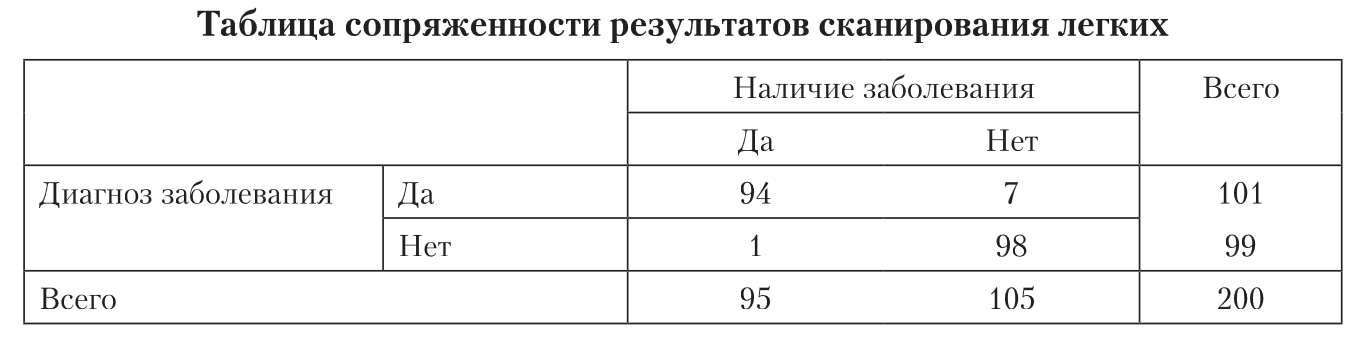

Согласно данным таблицы, есть 94 истинных «за» и $98$ истинных
«против», так что общая точность устройства (__accuracy, доля правильных ответов__) может быть оценена как
$(94 + 98) / 200 = 0.96 = 96\%$. Соответственно ложные «за» ($7$) и ложные «против»
($1$) в сумме дают $8$, т.е. $4\%$ ошибок.

Однако существует значительное различие между этими двумя видами ошибок. 
$7$ ложных «за» не так уж и важны — с этими пациентами ничего не случится;
дальнейшее исследование покажет отсутствие болезни — правда, с этим связаны
определенные затраты. В то же время одно ложное «против» может привести
к тому, что пациент останется без лечения, т.е. к потенциальной потере жизни
из-за ошибки устройства. Это пример того, как отличаются потери, связанные
с ложными «за» и «против». Сканер сделал лишь одну серьезную ошибку, не установив 
один из $95$ случаев заболевания раком. Доля истинных «за», равная доле верно установленных положительных случаев, часто называется мерой полноты или чувствительности (__recall, sensitivity, TPR, true positive rate__); в данном случае результат $94 / 95 = 98.9\%$ действительно впечатляет. С другой стороны, точность (__precision__), равная отношению $94$ истинных «за» к $101$ случаю диагноза «за» заболевание, несколько меньше, $93\%$, что показывает также и долю ложных «за» в $7\%$. Усредненное значение точности и чувствительности, равное $96\%$ в нашем случае, является достаточно хорошей мерой корректности (__accuracy rate__) данного устройства, и может быть выбрано для общей оценки качества в данном случае.

Однако в ситуациях, когда обнаруживается большая разница между размерами положительного («да») и отрицательного («нет») классов, данная мера корректности 
работает не лучшим образом. Рассмотрим результаты работы того же сканера, но теперь уже на другой, случайной, выборке $200$ человек «самотека», пришедших без направления врача.

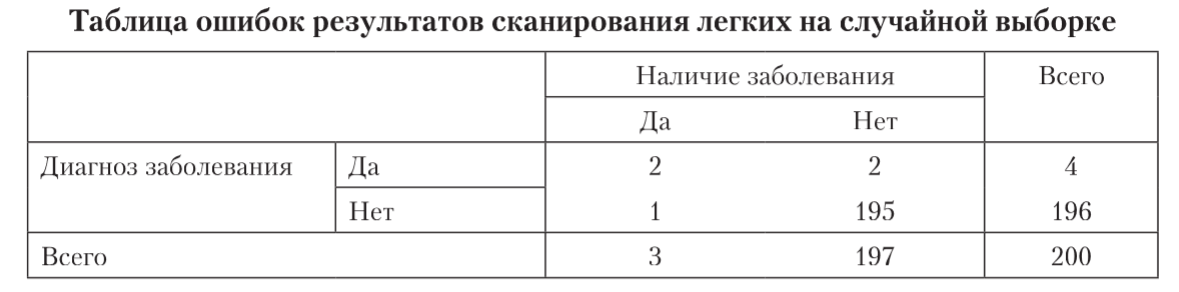

В данном случае величина корректности (accuracy) даже выше: $(2 + 195) / 200 = 98.5\%$. Тем не менее и чувствительность, $2 / 3 = 66.7\%$, и точность,
$2 / 4 = 50\%$, весьма далеки от этого уровня. Высокий уровень корректности обусловлен тем, что велика __специфичность (specificity, TNR, true negative rate)__ — доля правильно определенных случаев «нет», $195 / 197 = 98.9\%$, а также тем фактом, что в данной выборке очень мало случаев заболевания («да»).

Поэтому в качестве единой меры корректности, адекватно отражающей
и чувствительность, и точность, наиболее популярно не среднее арифметическое, 
а __среднее гармоническое__, так называемая __F-мера__, равная в данном случае

$$F = \frac{2}{1/(2/3) + 1/(2/4)} = \frac{4}{7} = 57.1\%.$$

Рассмотрим два положительных действительных числа $a$ и $b$
и предположим, что $a$ меньше $b$. Покажем, что среднее гармоническое 

$$h = \frac{2}{1/a + 1/b}$$

лежит в интервале от $a$ до $2a$, независимо от того, насколько велико $b$.

Представим $b$ в виде $b = ka$ с некоторым коэффициентом $k > 1$. Тогда

$$h = \frac{2}{1/a + 1/ka} = \frac{2k}{1 + k} a.$$

Коэффициент при $a$ стремится к $1$ при $k \to 1$ справа и к $2$ при $k \to +\infty$.

Рассмотрим два положительных действительных числа $a$ и $b$.
Покажем, что их среднее арифметическое, $m = (a + b) / 2$, и среднее гармоническое, $h = 2 / (1/a + 1/b)$, удовлетворяют уравнению $mh = ab$:

$$mh = \frac{a + b}{2} \cdot \frac{2ab}{a + b} = ab.$$

***
## <a id='toc1_3_'></a>[__Кластеризация методом *K*-средних__](#toc0_)

[__ml_cluster.ipynb__](https://github.com/EvgenyMeredelin/machine-learning-notes-and-codes/blob/main/ml_cluster/ml_cluster.ipynb)

Модель суммаризации, лежащая в основе метода, предполагает, что каждый
кластер представлен своим центром, иногда также называемым __стандартной точкой__, 
или __прототипом кластера__. Прототип как бы концентрирует в себе
всю информацию о кластере.

Очевидно, что результат сильно зависит от способа стандартизации данных,
сделанной перед началом вычислений, так как метод основан на расстояниях — суммах
квадратов разностей значений различных признаков, которые сильно зависят от выбранных 
масштабов.

In [13]:
companies = pd.read_csv('companies.csv', index_col='ID')
companies

,AnnualIncome,MarketShare,NCustomers,ECommerce,Industry
ID,,,,,
A1,19.0,0.2185,2,N,Chemicals
A2,29.4,0.1800,3,N,Chemicals
A3,23.9,0.1900,3,N,Metallurgy
B1,18.4,0.1395,2,Y,Chemicals
B2,25.7,0.1115,3,Y,Metallurgy
B3,12.1,0.0845,2,Y,Metallurgy
C1,23.9,0.1510,4,Y,Sales
C2,27.2,0.2900,5,Y,Sales


In [14]:
num_features = 'AnnualIncome', 'MarketShare', 'NCustomers'
cat_features = 'ECommerce', 'Industry'

[__sklearn.preprocessing.StandardScaler__](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn-preprocessing-standardscaler) | [__sklearn.preprocessing.OneHotEncoder__](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn-preprocessing-onehotencoder) | [__sklearn.compose.ColumnTransformer__](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html#sklearn-compose-columntransformer) | [__Introducing the set_output API__](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_set_output.html#introducing-the-set-output-api) | [__sklearn.cluster.KMeans__](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn-cluster-kmeans)

In [15]:
ct = ColumnTransformer(
    [('scaler', StandardScaler(), num_features),
     ('ohe', OneHotEncoder(sparse_output=False), cat_features)],
    #remainder='passthrough',
    verbose_feature_names_out=False
)

ct.set_output(transform='pandas')

ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                 ('AnnualIncome', 'MarketShare', 'NCustomers')),
                                ('ohe', OneHotEncoder(sparse_output=False),
                                 ('ECommerce', 'Industry'))],
                  verbose_feature_names_out=False)

In [16]:
companies_trans = ct.fit_transform(companies)
companies_trans

,AnnualIncome,MarketShare,NCustomers,ECommerce_N,ECommerce_Y,Industry_Chemicals,Industry_Metallurgy,Industry_Sales
ID,,,,,,,,
A1,-0.656310,0.791446,-1.0,1.0,0.0,1.0,0.0,0.0
A2,1.322132,0.154983,0.0,1.0,0.0,1.0,0.0,0.0
A3,0.275840,0.320298,0.0,1.0,0.0,0.0,1.0,0.0
B1,-0.770451,-0.514543,-1.0,0.0,1.0,1.0,0.0,0.0
B2,0.618263,-0.977425,0.0,0.0,1.0,0.0,1.0,0.0
B3,-1.968930,-1.423776,-1.0,0.0,1.0,0.0,1.0,0.0
C1,0.275840,-0.324431,1.0,0.0,1.0,0.0,0.0,1.0
C2,0.903615,1.973448,2.0,0.0,1.0,0.0,0.0,1.0


In [17]:
init = companies_trans.loc[['A2', 'B2', 'C1']]
km = KMeans(n_clusters=3, init=init, n_init=1).fit(companies_trans)
km.labels_

array([0, 0, 0, 1, 1, 1, 2, 2])

Метод K-средних имеет сильные стороны, обеспечивающие его популярность.
Концептуально он моделирует процесс создания типологии человеком, при этом
типы характеризуются центрами $c_k$ и кластерами $S_k$. Кроме того, алгоритм имеет
хорошие вычислительные характеристики: вычисления просты и интуитивны,
метод сходится быстро и не требует много памяти.

Метод имеет и слабые стороны:

* каким-то образом необходимо инициализировать число кластеров К
и начальные центры;
* результаты сильно зависят от инициализации и нормализации исходных
данных;
* метод не защищен от присутствия «случайных», «проходных» объектов
или признаков, которые могут сильно исказить результаты;
* не проработаны вопросы интерпретации кластеров в тех случаях, когда
центры не слишком отличаются от вектора средних на всем множестве.

In [18]:
iris_X, iris_y = load_iris(return_X_y=True)
iris_X_centered = StandardScaler(with_std=False).fit_transform(iris_X)

In [19]:
# k-means++, default
km = KMeans(n_clusters=3, n_init='auto', random_state=18)
km.fit(iris_X_centered)

KMeans(n_clusters=3, n_init='auto', random_state=18)

In [20]:
# 2 + 14 = 16 ошибок
cluster = pd.Series(km.labels_, name='cluster')
taxon = pd.Series(iris_y, name='taxon')
pd.crosstab(cluster, taxon, margins=True)

taxon,0,1,2,All
cluster,,,,
0,50,0,0,50
1,0,48,14,62
2,0,2,36,38
All,50,50,50,150


***
### <a id='toc1_3_1_'></a>[__Индекс Хартигана для выбора числа кластеров__](#toc0_)

Методы основан на многократном применении метода K-средних,
начиная со случайных $K$ центров, и обработке результатов. Обычно задаются
каким-либо числом прогонов, например $n = 100$, выбирают какой-либо диапазон
изменения $K$, после чего делают $n$ прогонов метода при каждом 
заданном $K$ из этого диапазона. Результат каждого такого прогона оценивают
критерием квадратичной ошибки (суммарной инерцией по всем кластерам). Обозначим через
$W_K$ минимальное из этих $n$ значений инерции. Последовательность $W_K$ при разных
$K$ из рассматриваемого диапазона значений используется для того, чтобы увидеть,
какое $K$ привело бы к лучшему значению $W_K$. К сожалению, лучшее $W_K$ не обязательно 
является минимумом $W_K$, потому что минимальное значение критерия
квадратичной ошибки может только убывать с ростом $K$ (математический факт).
Имеется ряд предложений о том, как использовать флуктуации в поведении $W_K$,
чтобы оценить «правильное» $K$. К сожалению, все они не очень надежны. Экспериментальный 
анализ показал, что одно из самых надежных — это «среднепотолочное» __правило Хартигана__. Правило Хартигана основано на том
предположении, что если имеется $K^*$ кластеров, четко отделенных друг от друга,
то для $K < K^*$ кластеров $(K + 1)$-кластерное разбиение по методу К-средних
должно походить на $K$-кластерное разбиение и получаться из него разделением
одного из кластеров на две части. При этом $W_{K+1}$ значительно меньше, чем $W_K$ (т.е. дальнейшее разбиение имеет смысл).
С другой стороны, при $K > K^*$, и $K$-кластерное и $(K + 1)$-кластерное разбиения
должны в основном совпадать с «правильным» $K^*$-кластерным разбиением с точностью 
до нескольких «правильных» случайно разделенных кластеров; при этом
$W_K$ и $W_{K+1}$ не сильно различаются. На основе этих соображений рассчитывается
индекс Хартигана:

$$H_K = (W_K / W_{K+1} - 1)(N - K - 1),$$

начиная с $K = 2$ и последовательно увеличивая $K$. $N$ — количество 
объектов. В качестве оценки $K^*$ при этом берется первое значение $K$,
при котором $H_K$ становится меньше, чем $10$. В экспериментах правило Хартигана оказалось наилучшим из девяти различных критериев, предложенных в литературе, причем порог $10$ оказался не сильно чувствительным к $10-20\%$-ым изменениям.

Короткий пересказ. Индекс Хартигана - это численный критерий остановки разбиения (роста числа кластеров $K$). Это как в каменистой осыпи: инерция будет гарантированно убывать с ростом $K$, но разбивать бесконечно нельзя, и нужно выбрать такое $K$, при котором прекращается резкое падение инерции.

In [21]:
iris_X_std = StandardScaler().fit_transform(iris_X)

См. атрибут __`inertia_`__ в [__sklearn.cluster.KMeans__](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn-cluster-kmeans)

На примере ирисов разберемся, почему "начальная", до разбиения на кластеры, инерция стандартизированных данных, т.е. когда кластер единственный - все объекты датасета, равна произведению числа объектов и числа признаков.

In [22]:
iris_X.shape

(150, 4)

In [23]:
np.multiply(*iris_X.shape)

600

[__scipy.spatial.distance.cdist__](https://scipy.github.io/devdocs/reference/generated/scipy.spatial.distance.cdist.html#scipy-spatial-distance-cdist)

In [24]:
centroid = iris_X_std.mean(axis=0)
cdist(iris_X_std, centroid.reshape(1,-1), 'sqeuclidean').sum()

600.0000000000001

Это то же самое что и

In [25]:
ddof = iris_X_std.shape[0] - 1
variance = iris_X_std.var(axis=0, ddof=ddof)
variance.sum()

599.9999999999998

In [26]:
variance

array([150., 150., 150., 150.])

Разберемся, почему сумма квадратов отклонений от среднего для стандартизированного столбца равна числу элементов в столбце:

$$S^2\left(\text{ddof}=N-1\right) = \frac{1}{N-N+1} \sum_{i=1}^N (z_i - \overline{z})^2 =$$

$$= \sum_{i=1}^N (\text{zscore}_i - 0)^2 = \sum_{i=1}^N \left(\frac{x_i - \overline{x}}{\sigma_x}\right)^2 = \frac{\sum_{i=1}^N (x_i - \overline{x})^2}{\sigma_x^2} = \frac{N \sigma_x^2}{\sigma_x^2} = N.$$

In [27]:
fields = 'inertia_descend', 'hartigan_index'
HartiganNClustersResult = namedtuple('HartiganNClustersResult', fields)

In [28]:
suptitle = ('Зависимость общей инерции от числа кластеров\n'
            'при разбиении пока индекс Хартигана $H \, \geqslant \, 10$.')

In [29]:
def hartigan_nclusters(X):
    inertia0 = np.multiply(*X.shape)
    inertia_descend = [(1, inertia0)]
    nclusters = 2

    while True:
        inertia_min = inertia0
        for _ in range(100):
            km = KMeans(nclusters, init='random', n_init=1).fit(X)
            if km.inertia_ < inertia_min:
                inertia_min = km.inertia_    
        hartigan_index = (
            (inertia_descend[-1][1] / inertia_min - 1) 
            * (X.shape[0] - inertia_descend[-1][0] - 1)
        )    
        if hartigan_index < 10:
            break    
        inertia_descend.append((nclusters, inertia_min))
        nclusters += 1
        
    x, y = zip(*inertia_descend)

    plt.figure(figsize=(6,3), dpi=120)
    plt.plot(x, y)
    plt.xticks(x)
    plt.xlabel('nclusters')
    plt.ylabel('inertia')
    plt.suptitle(suptitle, fontsize=10, y=0.99)
    
    return HartiganNClustersResult(inertia_descend, hartigan_index)

HartiganNClustersResult(
    inertia_descend=[
        (1, 600),
        (2, 222.36170496502308),
        (3, 139.82049635974982),
        (4, 114.09223843568272),
        (5, 90.8072831507854),
        (6, 80.02249599557437),
        (7, 70.65863985830326),
        (8, 62.47693170066394),
        (9, 54.527009633086045),
        (10, 47.39675833370692),
        (11, 42.784549651685225),
    ],
    hartigan_index=9.030971831944807,
)



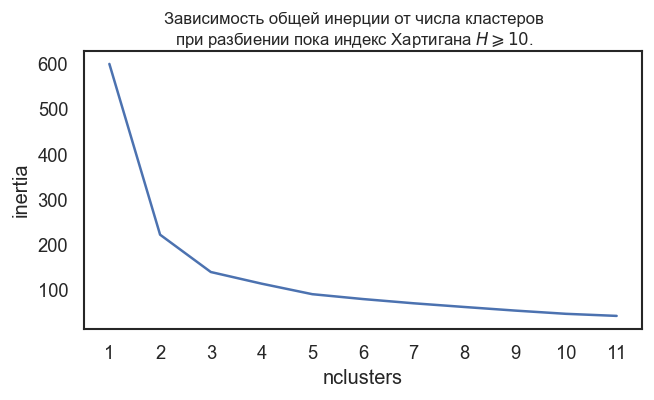

In [30]:
print_black(hartigan_nclusters(iris_X_std))

In [31]:
towns = pd.read_csv('england_sw_seaside_towns.csv', index_col='town')
towns.head()

,ppl,sch,thr,hsp,bnk,grc,gas,mat,swp,pof,law,frm
town,,,,,,,,,,,,
Mullion,2040,1,0,0,2,0,1,0,0,1,0,0
South Brent,2087,1,1,0,1,1,0,0,0,1,0,0
St Just,2092,1,0,0,2,1,1,0,0,1,0,0
St Columb Minor,2119,1,0,0,2,1,1,0,0,1,1,0
Nanpean,2230,2,1,0,0,0,0,0,0,2,0,0


In [32]:
towns.shape

(45, 12)

HartiganNClustersResult(
    inertia_descend=[(1, 540), (2, 277.46941765935463), (3, 218.66506300986032)],
    hartigan_index=8.776105825654337,
)



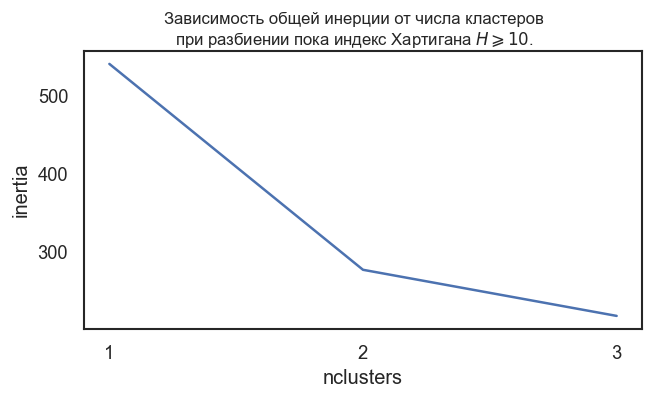

In [33]:
towns_std = StandardScaler().fit_transform(towns)
print_black(hartigan_nclusters(towns_std))

***
### <a id='toc1_3_2_'></a>[__Метод аномальных кластеров__](#toc0_)

Можно считать, что данный метод в какой-то мере «разведает»
структуру множества объектов. Он основан на последовательном выявлении 
и удалении так называемых аномальных групп. Аномальность понимается
как удаленность от некой «реперной» точки. Реперная точка выбирается как проявление 
«нормы», «среднего» или «нормального» объекта, не обязательно среди
множества наблюденных объектов. Например, при анализе оценок студентов
по различным предметам, можно выбрать точку, представляющую «нормального
студента», с оценками по контрольным работам и экзаменам, которые считаются
нормальными в данной среде, а затем уже выделять группы, наиболее отклоняющиеся 
от выбранной реперной точки в ту или иную сторону. Или же менеджер
банка может определить в качестве «нормы» группу клиентов с определенным
уровнем образования и дохода, а затем выделять «аномальные», отклоняющиеся
от нормы, группы клиентов.

Использование реперной точки позволяет сравнивать объекты не друг с другом, 
а именно с ней, что существенно экономит объем вычислений: вместо перебора 
всех парных расстояний между объектами, есть возможность сконцентрировать 
усилия на вычислении только расстояний между объектами и реперной
точкой, что дает снижение порядка количества шагов с $N^2$ до $N$.

Аномальная группа конструируется как кластер, наиболее удаленный от реперной 
точки. Процесс начинается с того, что объект, наиболее удаленный от реперной 
точки, объявляется центром аномальной группы. Затем версия метода
К-средних с $K = 2$ применяется к двум центрам: один — это реперная точка, которая 
__не меняется все время процесса вычислений__, а второй — это центр аномальной 
группы, который обновляется согласно стандартной процедуре. А именно,
при заданном аномальном центре, аномальная группа определяется как множество 
объектов, которые ближе к этому центру, чем реперной точке. При заданной
аномальной группе ее центр вычисляется как центр масс с помощью нахождения
среднего всех входящих в группу объектов. Процедура повторяется до тех пор,
пока не сойдется.

In [34]:
def get_anomaly_group_indices(X):
    centroid0 = [[0] * X.shape[1]]
    distances = cdist(X, centroid0, 'sqeuclidean')
    anom_centroid_index = np.argmax(distances)
    anom_group_indices = {anom_centroid_index}
    anom_centroid = X[anom_centroid_index].reshape(1,-1)    
    get_centroids = lambda: np.r_[centroid0, anom_centroid]
    
    while True:
        distances = cdist(X, get_centroids(), 'sqeuclidean')
        labels = np.argmin(distances, axis=1)
        anom_indices = np.nonzero(labels)[0]
        anom_group_updated = anom_group_indices | set(anom_indices)
        if anom_group_updated == anom_group_indices:
            break
        anom_group_indices = anom_group_updated
        anom_centroid = X[anom_indices].mean(axis=0).reshape(1,-1)
    
    return list(anom_group_indices)

In [35]:
ix = get_anomaly_group_indices(scale(towns))
towns.iloc[ix]

,ppl,sch,thr,hsp,bnk,grc,gas,mat,swp,pof,law,frm
town,,,,,,,,,,,,
Tavistock,10222,5,3,1,7,3,3,1,2,3,1,1
Brixham,15865,7,3,1,5,5,3,0,2,5,1,0
Newquay,17390,4,4,1,12,5,4,0,1,5,1,0
Truro,18966,9,3,1,19,4,5,2,2,7,1,1
Penzance,19709,10,4,1,12,7,5,1,1,7,2,0
Falmouth,20297,6,4,1,11,3,2,0,1,9,1,0
St Austell,21622,7,4,2,14,6,4,3,1,8,1,1
Newton Abbot,23801,13,4,1,13,4,7,1,1,7,2,0


Полученная аномальная группа состоит из городов с высоким
уровнем значений показателей — все значения в центре аномальной группы больше, чем средние на всем множестве, на $30—50\%$ размаха значений признаков. Возможно, это связано с тем, что группа включает $8$ из $11$ городов с населением _ppl_ более $10$ тыс. человек. Остальные три больших города не попали в группу из-за недостатка в них таких характеристик, как больницы _hsp_ и фермерские рынки _frm_.

Последовательная декомпозиция всего набора данных на аномальные кластеры:

In [36]:
def get_anomaly_groups_labels(X):
    labels = np.zeros((X.shape[0],), dtype=int)
    label = 1
    while labels.__contains__(0):
        ix = get_anomaly_group_indices(X[labels == 0])
        labels[np.where(labels == 0)[0][ix]] = label
        label += 1
    return labels

In [37]:
get_anomaly_groups_labels(scale(towns))

array([ 3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  8,  3, 13,  5, 13,  5,  7,  5, 11, 12,  2, 10,  5,  6,  9,
       10,  1,  4,  4,  1,  1,  1,  1,  1,  1,  1])

Диаграммы рассеяния ниже сугубо для выработки геометрической интуиции для понимания метода: из данных последовательно выводятся кластеры, порожденные объектом (прототипом, или центроидом), наиболее удаленным от $(0,0)$ на текущей итерации. Граница кластера перпендикулярна линии, соединяющей прототип кластера с $(0,0)$.

In [38]:
aes = dict(lw=0.3, ec='w', cmap='tab20')

In [39]:
def plot_anomaly_groups(X):
    labels = get_anomaly_groups_labels(X)
    plt.figure(figsize=(7,7), dpi=120)
    plt.scatter(*X.T, c=labels, **aes)
    plt.gca().set_aspect('equal')

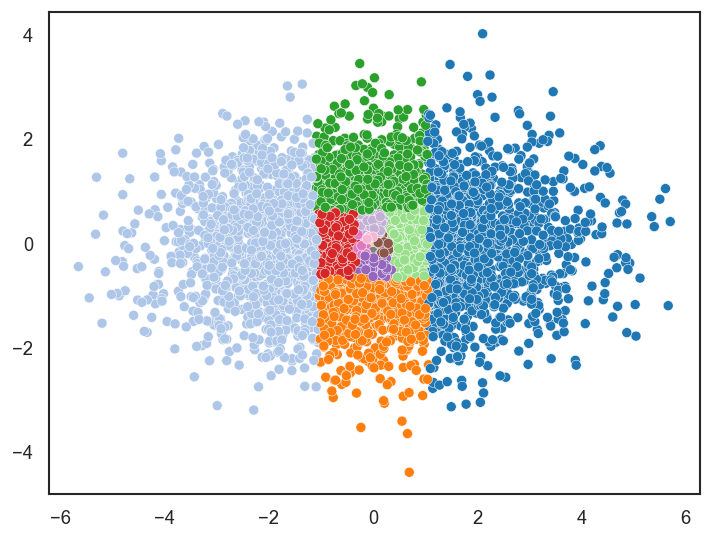

In [40]:
rng = np.random.default_rng(42)
X = rng.multivariate_normal(
    mean=[0, 0], 
    cov=[[3, 0], [0, 1]], 
    size=5000
)
plot_anomaly_groups(X)

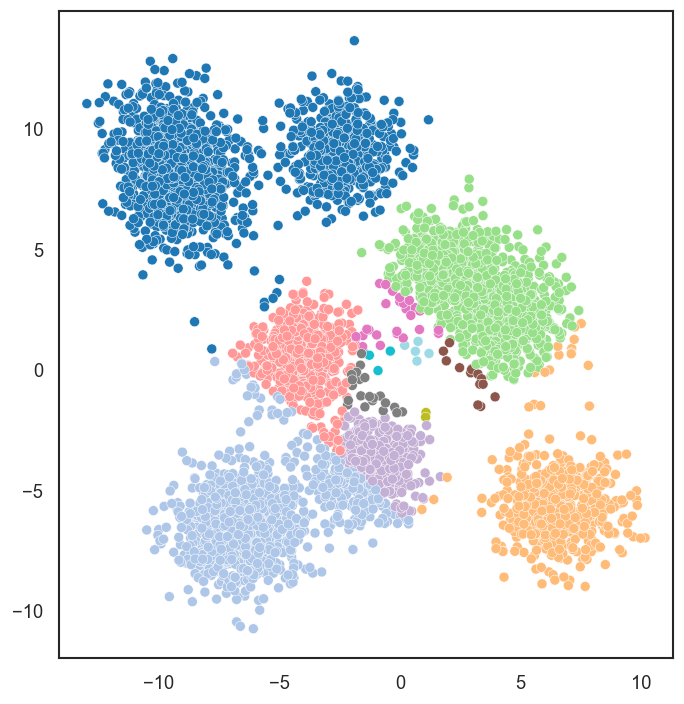

In [41]:
X, _ = make_blobs(
    n_samples=5000, 
    centers=10,
    cluster_std=1.2,
    random_state=42
)
plot_anomaly_groups(X)

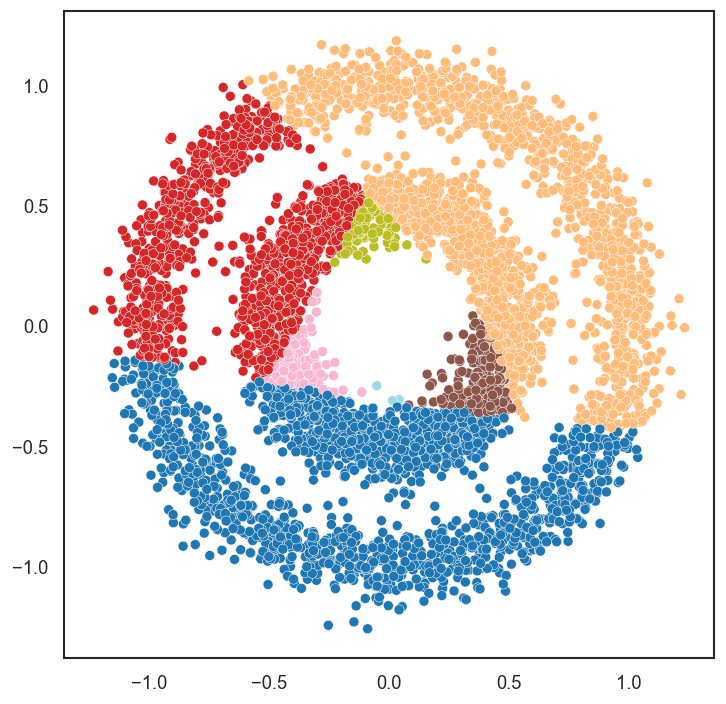

In [42]:
X, _ = make_circles(
    n_samples=5000, 
    noise=0.08, 
    factor=0.5,
    random_state=42
)
plot_anomaly_groups(X)